In [1]:
import os

In [2]:
os.chdir(r"C:\Users\yozhan\cryptocurrency")

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
from cryptocmd import CmcScraper

In [5]:
scraper = CmcScraper("BTC")
headers, data = scraper.get_data()

In [6]:
from datetime import datetime

In [7]:
start_date = datetime.strptime("01-01-2022", r"%d-%m-%Y")
end_date = datetime.strptime("31-12-2022", r"%d-%m-%Y")

In [8]:
bitcoin_price_list = []
date_list = []

for record in data:
    date = datetime.strptime(record[0], r"%d-%m-%Y")
    if(date >= start_date and date <= end_date):
        date_list.append(date)
        
        
        # Note: here we should make each price as a single-element list
        bitcoin_price_list.append([record[1]])

        
date_list.reverse()
bitcoin_price_list.reverse()

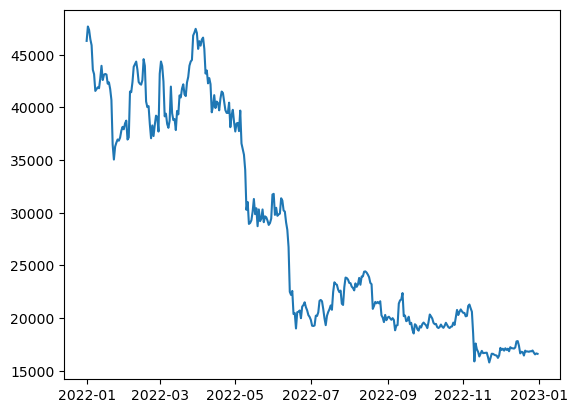

In [9]:
plt.plot(date_list, bitcoin_price_list)
plt.show()

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(bitcoin_price_list)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
normalized = scaler.transform(bitcoin_price_list)

Min: 15782.301231, Max: 47680.926625


In [12]:
# normalized

train_size = int(len(normalized) * 0.75)
train, test = normalized[:train_size], normalized[train_size:]

In [13]:
import torch
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [17]:
lookback = 30
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# window sample, time steps, features

torch.Size([243, 30, 1]) torch.Size([243, 30, 1])
torch.Size([62, 30, 1]) torch.Size([62, 30, 1])


In [18]:
import torch.nn as nn
 
class CryptoModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        #input_size: how many features (currently only 1, the time series from previous days)
        #if more features are used (for example, text features, sentiment scores, then input_size should be larger)
        
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x = x.float()
        x, _ = self.lstm(x)
        x = x[:, -1:, :]
        x = self.linear(x)
        return x

In [19]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = CryptoModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:  
        
        X_batch, y_batch = X_batch.float(), y_batch.float()
        
        X_batch = X_batch.float()
        y_pred = model(X_batch)
        
        loss = loss_fn(y_pred, y_batch[:, -1:, :])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred[:, -1:, :], y_train[:, -1:, :]))
        
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred[:, -1:, :], y_test[:, -1:, :]))
        
        
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.2294, test RMSE 0.3820
Epoch 100: train RMSE 0.0398, test RMSE 0.0316
Epoch 200: train RMSE 0.0355, test RMSE 0.0275
Epoch 300: train RMSE 0.0327, test RMSE 0.0200
Epoch 400: train RMSE 0.0299, test RMSE 0.0235
Epoch 500: train RMSE 0.0299, test RMSE 0.0203
Epoch 600: train RMSE 0.0226, test RMSE 0.0211
Epoch 700: train RMSE 0.0206, test RMSE 0.0372
Epoch 800: train RMSE 0.0202, test RMSE 0.0477
Epoch 900: train RMSE 0.0165, test RMSE 0.0383
Epoch 1000: train RMSE 0.0148, test RMSE 0.0381
Epoch 1100: train RMSE 0.0145, test RMSE 0.0415
Epoch 1200: train RMSE 0.0103, test RMSE 0.0359
Epoch 1300: train RMSE 0.0111, test RMSE 0.0369
Epoch 1400: train RMSE 0.0071, test RMSE 0.0373
Epoch 1500: train RMSE 0.0066, test RMSE 0.0425
Epoch 1600: train RMSE 0.0064, test RMSE 0.0462
Epoch 1700: train RMSE 0.0093, test RMSE 0.0499
Epoch 1800: train RMSE 0.0085, test RMSE 0.0397
Epoch 1900: train RMSE 0.0070, test RMSE 0.0444


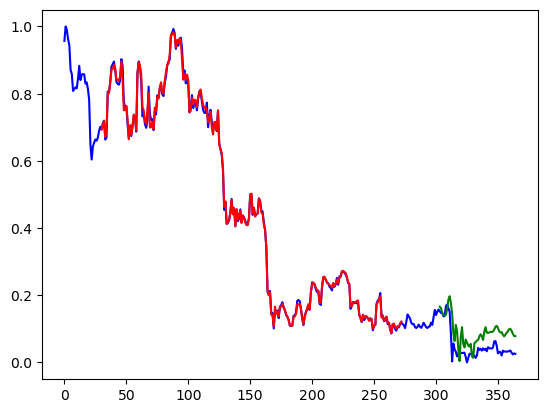

In [20]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(bitcoin_price_list) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(bitcoin_price_list) * np.nan
    test_plot[train_size+lookback:len(bitcoin_price_list)] = model(X_test)[:, -1, :]
# plot
plt.plot(normalized, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

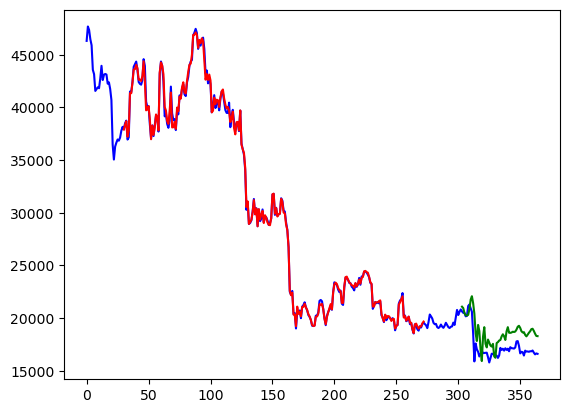

In [21]:
with torch.no_grad():
    
    # shift train predictions for plotting
    train_plot = np.ones_like(bitcoin_price_list) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_inversed = scaler.inverse_transform(model(X_train)[:, -1, :])
    train_plot[lookback:train_size] = train_inversed
    # shift test predictions for plotting
    test_plot = np.ones_like(bitcoin_price_list) * np.nan
    test_inversed = scaler.inverse_transform(model(X_test)[:, -1, :])
    test_plot[train_size+lookback:len(bitcoin_price_list)] = test_inversed

# plot
plt.plot(bitcoin_price_list, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()    

In [22]:
from math import sqrt
from sklearn.metrics import mean_squared_error

In [23]:
rmse = sqrt(mean_squared_error(bitcoin_price_list[train_size+lookback:], test_inversed))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1613.504


In [24]:
bitcoin_train, bitcoin_test = bitcoin_price_list[:train_size], bitcoin_price_list[train_size:]

In [25]:
# get previous day's opening price
# because of the lookback (currently=4), the previous price set starts from position 3

bitcoin_test_previous_price = bitcoin_test.copy()[lookback-1:][:-1]

In [26]:
bitcoin_true_label = []


bitcoin_test = bitcoin_test.copy()[lookback:]
for i, _ in enumerate(bitcoin_test):
    if(bitcoin_test[i] > bitcoin_test_previous_price[i]):
        bitcoin_true_label.append("Increase")
    else:
        bitcoin_true_label.append("Decrease")

In [27]:
bitcoin_predict_label = []
for i, _ in enumerate(test_inversed):
    if(test_inversed[i] > bitcoin_test_previous_price[i]):
        bitcoin_predict_label.append("Increase")
    else:
        bitcoin_predict_label.append("Decrease")

In [28]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [29]:
print(classification_report(bitcoin_true_label, bitcoin_predict_label))

              precision    recall  f1-score   support

    Decrease       0.67      0.11      0.19        36
    Increase       0.43      0.92      0.59        26

    accuracy                           0.45        62
   macro avg       0.55      0.52      0.39        62
weighted avg       0.57      0.45      0.36        62

